In [ ]:
!pip install pycaret
# autoML(pycaret) 설치 오류 발생 : ERROR: Could not build wheels for lightgbm, which is required to install pyproject.toml-based projects
!pip install --upgrade pip
!pip install \
   --no-binary lightgbm \
   --config-settings=cmake.define.USE_OPENMP=OFF \
   'lightgbm>=4.0.0'
!pip install shap

In [2]:
# Standard
import pandas as pd
import numpy as np
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
import interpret
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
DATA_DIR = "../../data/"
df = pd.read_pickle(DATA_DIR + 'base_dataset_standardized.pkl')
# df = pd.read_pickle(DATA_DIR + 'base_dataset_before_std.pkl')

# df = df.drop(['Total_Trans_Ct'], axis=1)
# df = df.drop(['Total_Trans_Amt'], axis=1)
# df = df.drop(['Months_on_book'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer_Age               10127 non-null  float64
 1   Dependent_count            10127 non-null  float64
 2   Education_Level            10127 non-null  float64
 3   Income_Category            10127 non-null  float64
 4   Card_Category              10127 non-null  float64
 5   Months_on_book             10127 non-null  float64
 6   Total_Relationship_Count   10127 non-null  float64
 7   Months_Inactive_12_mon     10127 non-null  float64
 8   Contacts_Count_12_mon      10127 non-null  float64
 9   Credit_Limit               10127 non-null  float64
 10  Total_Revolving_Bal        10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1       10127 non-null  float64
 12  Total_Trans_Amt            10127 non-null  float64
 13  Total_Trans_Ct             10127 non-null  flo

In [5]:
random_seed = 0
train_size = 0.8
fix_imbalance = True # True : upsampling
fix_imbalance_method = 'SMOTE' # default method : SMOTE. Ignored when fix_imbalance=False

stp = setup(data=df, target='Attrition_Flag', \
    train_size=train_size, \
    fix_imbalance=fix_imbalance, \
    fix_imbalance_method=fix_imbalance_method, \
    session_id=random_seed)

,Description,Value
0,Session id,0
1,Target,Attrition_Flag
2,Target type,Binary
3,Original data shape,"(10127, 21)"
4,Transformed data shape,"(15624, 21)"
5,Transformed train set shape,"(13598, 21)"
6,Transformed test set shape,"(2026, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


In [6]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9722,0.9926,0.9109,0.9161,0.9133,0.8968,0.8969,0.0470
lightgbm,Light Gradient Boosting Machine,0.9700,0.9927,0.9079,0.9058,0.9067,0.8888,0.8889,0.0550
gbc,Gradient Boosting Classifier,0.9604,0.9874,0.9102,0.8535,0.8806,0.8569,0.8578,0.7660
rf,Random Forest Classifier,0.9585,0.9867,0.8741,0.8690,0.8713,0.8466,0.8467,0.2890
et,Extra Trees Classifier,0.9462,0.9779,0.7726,0.8780,0.8214,0.7899,0.7925,0.1350
ada,Ada Boost Classifier,0.9433,0.9799,0.9040,0.7799,0.8369,0.8029,0.8064,0.1530
dt,Decision Tree Classifier,0.9264,0.8829,0.8188,0.7493,0.7817,0.7376,0.7392,0.0350
qda,Quadratic Discriminant Analysis,0.8779,0.9314,0.7750,0.6036,0.6733,0.6007,0.6117,0.0090
lr,Logistic Regression,0.8529,0.9267,0.8464,0.5271,0.6493,0.5626,0.5881,0.1990
ridge,Ridge Classifier,0.8456,0.0000,0.8549,0.5124,0.6404,0.5499,0.5794,0.0080


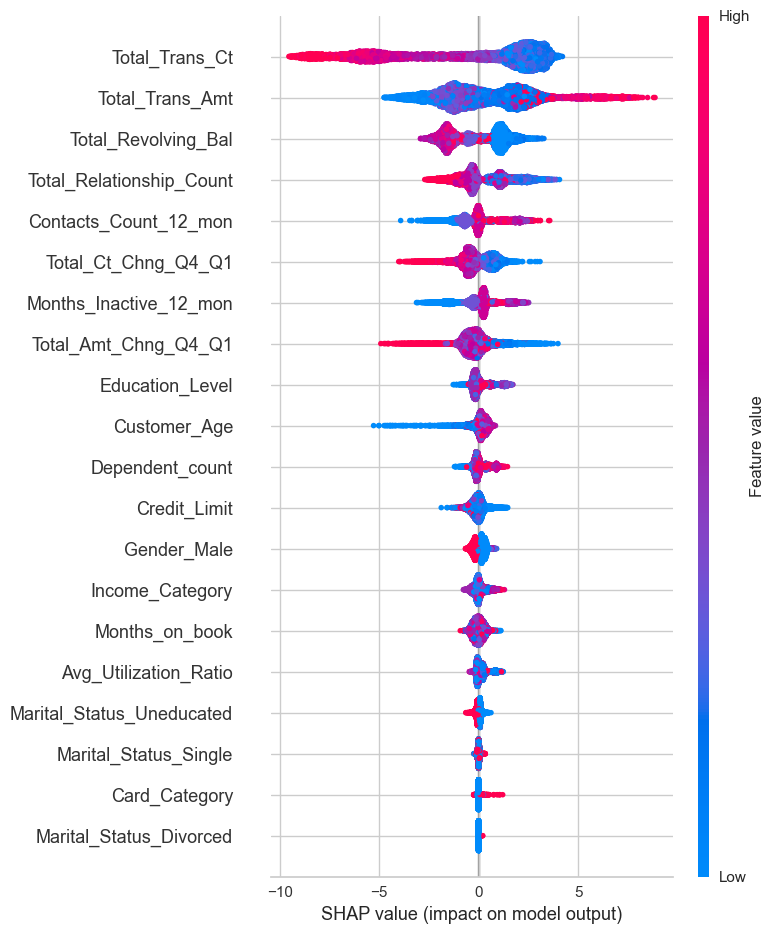

In [27]:
interpret_model(best_model, use_train_data=True)

In [30]:
interpret_model(best_model, plot='reason', observation=240) # observation means index from the test set.

In [8]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [9]:
xgb_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9704,0.9903,0.8779,0.9350,0.9055,0.8880,0.8886
1,0.9765,0.9938,0.9385,0.9173,0.9278,0.9138,0.9138
2,0.9654,0.9837,0.8923,0.8923,0.8923,0.8717,0.8717
3,0.9778,0.9947,0.9231,0.9375,0.9302,0.9170,0.9171
4,0.9728,0.9957,0.9154,0.9154,0.9154,0.8992,0.8992
5,0.9741,0.9936,0.9308,0.9098,0.9202,0.9047,0.9048
6,0.9654,0.9921,0.8923,0.8923,0.8923,0.8717,0.8717
7,0.9765,0.9945,0.9077,0.9440,0.9255,0.9116,0.9118
8,0.9765,0.9945,0.9385,0.9173,0.9278,0.9138,0.9138


In [10]:
result = pull(xgb_model)
print(type(result))
print(result)
print(result.shape)

<class 'pandas.core.frame.DataFrame'>
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9704  0.9903  0.8779  0.9350  0.9055  0.8880  0.8886
1       0.9765  0.9938  0.9385  0.9173  0.9278  0.9138  0.9138
2       0.9654  0.9837  0.8923  0.8923  0.8923  0.8717  0.8717
3       0.9778  0.9947  0.9231  0.9375  0.9302  0.9170  0.9171
4       0.9728  0.9957  0.9154  0.9154  0.9154  0.8992  0.8992
5       0.9741  0.9936  0.9308  0.9098  0.9202  0.9047  0.9048
6       0.9654  0.9921  0.8923  0.8923  0.8923  0.8717  0.8717
7       0.9765  0.9945  0.9077  0.9440  0.9255  0.9116  0.9118
8       0.9765  0.9945  0.9385  0.9173  0.9278  0.9138  0.9138
9       0.9667  0.9929  0.8931  0.9000  0.8966  0.8767  0.8767
Mean    0.9722  0.9926  0.9109  0.9161  0.9133  0.8968  0.8969
Std     0.0047  0.0033  0.0205  0.0174  0.0146  0.0174  0.0174
(12, 7)


In [11]:
auc = result.loc['Mean', 'AUC']
recall = result.loc['Mean', 'Recall']
prec = result.loc['Mean', 'Prec']


print(f'{auc} : {recall}')

0.9926 : 0.9109


In [12]:
print(f'1681/(1681+20) = {1681/(1681+20)}') # AUC
print(f'1681/(1681+41) = {1681/(1681+41)}')
print(f'284/(284+41) = {284/(284+41)}')
print(f'284/(284+20) = {284/(284+20)}') # Recall

1681/(1681+20) = 0.9882422104644327
1681/(1681+41) = 0.9761904761904762
284/(284+41) = 0.8738461538461538
284/(284+20) = 0.9342105263157895


In [33]:
from sklearn.metrics import confusion_matrix

def find_optimal_x(TP, FP, TN, FN, 손실, 투자):
    # 예상 손실과 투자예상 계산
    예상손실 = 손실 * (FP + TN)
    투자예상 = 투자 * (FN + TN)
    
    # 보존투자금 계산
    보존투자금 = 예상손실 - 투자예상

    # 최대 보존투자금을 만드는 x 찾기
    if 예상손실 <= 투자예상:
        return 0  # 예상손실이 투자예상보다 작으면 x는 0이어야 합니다.
    else:
        x = 투자 * (FN + TN) / (손실 * (FP + TN))
        return x

# 예시: confusion matrix의 값들을 직접 입력하고 손실과 투자를 설정
TP = 50
FP = 10
TN = 200
FN = 5
손실 = 100
투자 = 50

# 최적의 x를 찾기
optimal_x = find_optimal_x(TP, FP, TN, FN, 손실, 투자)
print("최적의 x:", optimal_x)

최적의 x: 0.4880952380952381


In [37]:
from sklearn.metrics import confusion_matrix

def find_optimal_x_from_metrics(accuracy, recall, prec, 손실):
    # 모든 가능한 x에 대한 confusion matrix 생성
    # 이때 recall과 precision을 이용하여 FN, FP 계산
    x_values = []
    for x in range(100):
        TP = accuracy * x
        FN = recall * TP / (1 - recall)
        FP = (TP / prec) - TP
        TN = x - TP - FP - FN
        x_values.append((x, TP, FP, TN, FN))
    print(x_values)
    [99, ]
    # 보존투자금을 계산하고 최대값을 가지는 x를 찾기
    max_investment = float("-inf")
    optimal_x = None
    for x, TP, FP, TN, FN in x_values:
        예상손실 = 손실 * (FP + TN)
        투자예상 = x * (FN + TN)
        보존투자금 = 예상손실 - 투자예상
        if 보존투자금 > max_investment:
            max_investment = 보존투자금
            optimal_x = x

    return optimal_x

# 예시: Accuracy, AUC, Recall, Precision, F1 Score, 손실 값을 주어진 경우
accuracy = 0.9
recall = 0.8
prec = 0.75
손실 = 100

# 최적의 x를 찾기
optimal_x = find_optimal_x_from_metrics(accuracy, recall, prec, 손실)
print("최적의 x:", optimal_x)

최적의 x: 0


In [42]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def objective_function(x, 손실, accuracy, recall, prec):
    TP = accuracy * x
    FN = recall * TP / (1 - recall)
    FP = (TP / prec) - TP
    TN = x - TP - FP - FN

    예상손실 = 손실 * (FP + TN)
    투자예상 = x * (FN + TN)
    보존투자금 = 예상손실 - 투자예상
    return -보존투자금  # 최대화 문제를 최소화 문제로 바꿉니다.

def find_optimal_x_from_metrics(accuracy, recall, prec, 손실):
    # 초기 추정치 x0를 설정합니다.
    x0 = 0

    # 최적화 알고리즘을 사용하여 목적 함수를 최소화합니다.
    result = minimize(objective_function, x0, args=(손실, accuracy, recall, prec), bounds=[(0, None)])

    # 최적의 x 값을 반환합니다.
    optimal_x = result.x[0]
    return optimal_x

# 예시: Accuracy, Recall, Precision, 손실 값을 주어진 경우
accuracy = 0.99
recall = 0.98
prec = 0.89
손실 = 500

# 최적의 x를 찾기
optimal_x = find_optimal_x_from_metrics(accuracy, recall, prec, 손실)
print("최적의 x:", optimal_x)


최적의 x: 0.0


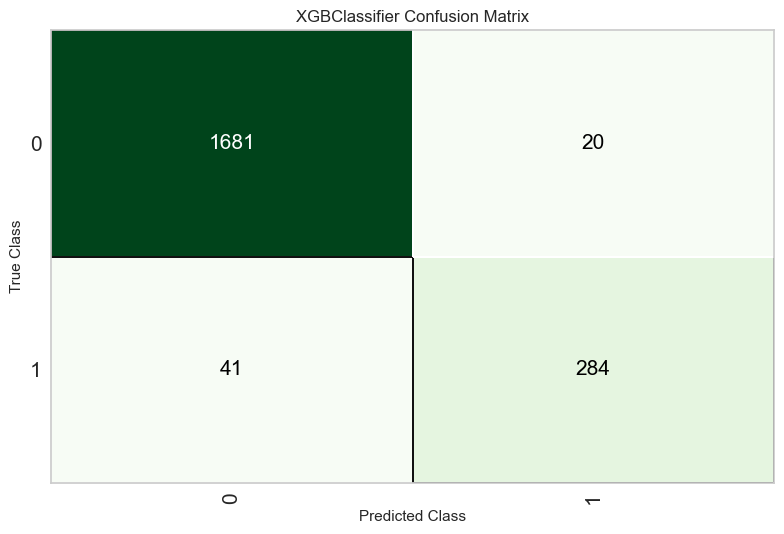

In [31]:
plot_model(xgb_model, plot='confusion_matrix')

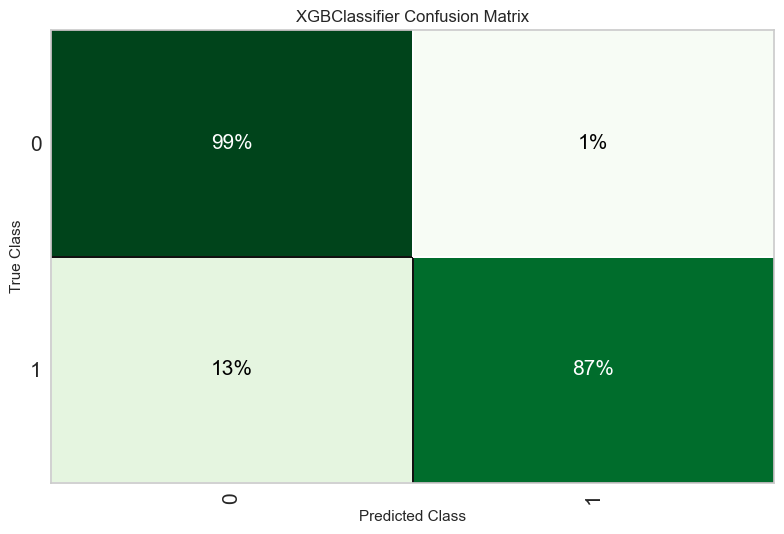

In [13]:
plot_model(xgb_model, plot='confusion_matrix', plot_kwargs = {'percent' : True})

In [14]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [15]:
tune_xgb_model = tune_model(xgb_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9630,0.9905,0.9313,0.8531,0.8905,0.8683,0.8695
1,0.9679,0.9941,0.9538,0.8611,0.9051,0.8859,0.8875
2,0.9531,0.9845,0.9231,0.8108,0.8633,0.8351,0.8377
3,0.9741,0.9948,0.9538,0.8921,0.9219,0.9064,0.9071
4,0.9642,0.9944,0.9846,0.8258,0.8982,0.8767,0.8817
5,0.9593,0.9921,0.9769,0.8089,0.8850,0.8605,0.8662
6,0.9543,0.9887,0.9308,0.8121,0.8674,0.8399,0.8428
7,0.9654,0.9937,0.9538,0.8493,0.8986,0.8778,0.8799
8,0.9630,0.9940,0.9615,0.8333,0.8929,0.8706,0.8739


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


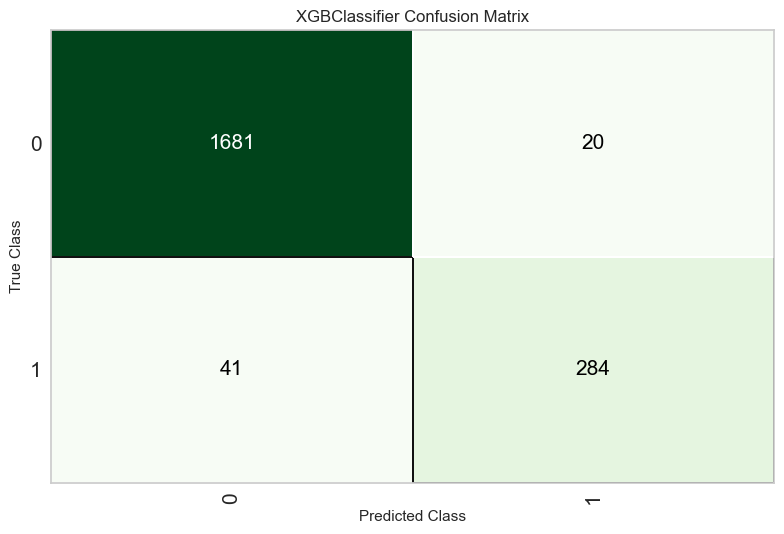

In [16]:
plot_model(tune_xgb_model, plot='confusion_matrix')

In [17]:
predict_model(tune_xgb_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9699,0.9925,0.8738,0.9342,0.9030,0.8852,0.8859


,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Male,Marital_Status_Uneducated,Marital_Status_Single,Marital_Status_Divorced,Attrition_Flag,prediction_label,prediction_score
8708,0.583058,-0.266547,-0.657196,-0.281087,-0.250587,0.008965,-1.166148,-0.337598,-1.315636,0.678678,...,1.241566,-0.500778,-0.746863,-0.943436,1.037331,-0.892124,-0.285046,0,0,0.9997
9115,1.206778,-1.806378,-0.657196,2.035710,-0.250587,1.636809,-1.166148,-0.337598,-0.411616,2.848054,...,0.559886,0.427504,-0.772255,1.059956,1.037331,-0.892124,-0.285046,0,1,0.8259
1960,2.204730,-1.806378,0.159721,-1.053353,-0.250587,2.137684,-0.522785,0.651940,1.396423,-0.720479,...,-1.186920,-0.714997,1.868509,1.059956,1.037331,-0.892124,-0.285046,0,0,0.9917
6540,-0.789126,1.273283,0.159721,-1.053353,-0.250587,-1.368442,1.407306,-0.337598,-1.315636,-0.640377,...,0.389466,0.209084,1.621844,-0.943436,-0.964012,1.120920,-0.285046,0,0,1.0000
9309,-0.040662,-0.266547,0.159721,2.035710,2.745506,0.384621,-1.166148,-0.337598,0.492404,2.848054,...,2.093666,1.065960,-0.852058,1.059956,1.037331,-0.892124,-0.285046,0,0,0.9985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,-1.787077,-1.806378,-1.474113,-0.281087,-0.250587,0.008965,1.407306,0.651940,-0.411616,0.017500,...,-0.590450,-0.496578,-0.997155,-0.943436,1.037331,-0.892124,-0.285046,1,0,0.7849
5687,-1.537589,-0.266547,0.976638,-1.053353,-0.250587,-1.994536,0.763943,-0.337598,0.492404,-0.651050,...,0.133835,-0.223554,1.012437,-0.943436,-0.964012,1.120920,-0.285046,0,0,0.9995
9232,-0.165406,2.043199,-1.474113,1.263444,-0.250587,-0.241473,-1.166148,0.651940,0.492404,-0.571827,...,-0.590450,-0.702396,1.661746,1.059956,1.037331,-0.892124,-0.285046,1,1,0.9991
2704,0.208826,0.503368,0.159721,1.263444,-0.250587,0.259402,-0.522785,0.651940,0.492404,2.516309,...,0.432071,0.309893,-0.997155,1.059956,1.037331,-0.892124,-0.285046,0,0,0.9992


In [18]:
model_final = finalize_model(tune_xgb_model)

In [19]:
print(model_final)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Customer_Age', 'Dependent_count',
                                             'Education_Level',
                                             'Income_Category', 'Card_Category',
                                             'Months_on_book',
                                             'Total_Relationship_Count',
                                             'Months_Inactive_12_mon',
                                             'Contacts_Count_12_mon',
                                             'Credit_Limit',
                                             'Total_Revolving_Bal',
                                             'Total_Amt_Chng_Q4_Q1',
                                             'Tota...
                               importance_type=None,
                               interaction_constraints=None, learn

In [20]:
model_final

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Customer_Age', 'Dependent_count',
                                             'Education_Level',
                                             'Income_Category', 'Card_Category',
                                             'Months_on_book',
                                             'Total_Relationship_Count',
                                             'Months_Inactive_12_mon',
                                             'Contacts_Count_12_mon',
                                             'Credit_Limit',
                                             'Total_Revolving_Bal',
                                             'Total_Amt_Chng_Q4_Q1',
                                             'Tota...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

프로모션, 마케팅 투자비용


# 컬럼 제거 없이

In [21]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [22]:
evaluate_model(best_model) # feature 변경 없ㅇ

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…